In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from tqdm import tqdm
import shutil
import random
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data= '/content/drive/MyDrive/Colab Notebooks/buah'

In [ ]:
simpan= '/content/drive/MyDrive/Colab Notebooks/Buah-buahan'

In [ ]:
train_data = os.path.join(simpan, 'train')
test_data = os.path.join(simpan, 'test')
val_data = os.path.join(simpan, 'val')

In [ ]:
train_split = 0.8
val_split = 0.1
test_split = 0.1

In [ ]:
for split_dir in [train_data, val_data, test_data]:
    os.makedirs(split_dir, exist_ok=True)

In [ ]:
for class_name in tqdm(os.listdir(data)):
    class_path = os.path.join(data, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    n_total = len(images)
    n_train = int(train_split * n_total)
    n_val = int(val_split * n_total)

    train_images = images[:n_train]
    val_images = images[n_train:n_train+n_val]
    test_images = images[n_train+n_val:]

    for split_name, split_images in zip(
        ['train', 'val', 'test'],
        [train_images, val_images, test_images]
    ):
        split_class_dir = os.path.join(simpan, split_name, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for img_name in split_images:
            src = os.path.join(class_path, img_name)
            dst = os.path.join(split_class_dir, img_name)
            shutil.copy2(src, dst)

100%|██████████| 10/10 [04:20<00:00, 26.02s/it]


In [ ]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True)

In [ ]:
val_datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2)
test_datagen=ImageDataGenerator(rescale=1./255)

In [ ]:
train_data = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/Buah-buahan/train',
    target_size=(150, 150),
    batch_size=32,
    subset='training',
    class_mode='categorical')

Found 8000 images belonging to 10 classes.


In [ ]:
test_data = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/Buah-buahan/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

Found 1000 images belonging to 10 classes.


In [ ]:
val_data = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/Buah-buahan/val',
    target_size=(150, 150),
    batch_size=32,
    subset='validation',
    class_mode='categorical')

Found 200 images belonging to 10 classes.


In [ ]:
from sklearn.utils import class_weight
import numpy as np

labels = train_data.classes  # ini list label dari ImageDataGenerator

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights))

print(class_weights)


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64,(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_data.num_classes, activation='softmax'),
])
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# estop=EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
checkpoint = ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min'
)

estop = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
        mode='max'
)

In [ ]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,913,696 (121.74 MB)

 Trainable params: 10,637,834 (40.58 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 21,275,670 (81.16 MB)

In [ ]:
model_history = model.fit(train_data,
          validation_data=val_data,
          epochs=10,
          batch_size=32,
          callbacks=[checkpoint,estop])

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 70s 279ms/step - accuracy: 0.9329 - loss: 0.2174 - val_accuracy: 0.9300 - val_loss: 0.1958
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 71s 284ms/step - accuracy: 0.9237 - loss: 0.2355 - val_accuracy: 0.9550 - val_loss: 0.1047
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 274ms/step - accuracy: 0.9336 - loss: 0.1917 - val_accuracy: 0.9200 - val_loss: 0.1809
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 275ms/step - accuracy: 0.9271 - loss: 0.2337 - val_accuracy: 0.9600 - val_loss: 0.1182
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 70s 278ms/step - accuracy: 0.9332 - loss: 0.2214 - val_accuracy: 0.9700 - val_loss: 0.0924
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 281ms/step - accuracy: 0.9402 - loss: 0.1778 - val_accuracy: 0.9350 - val_loss: 0.1569
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 275ms/step - accuracy: 0.9388 - loss: 0.2056 - val_accuracy: 0.9650 - val_loss: 0.1272
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 274ms/step - accuracy: 0.9341 - loss: 0

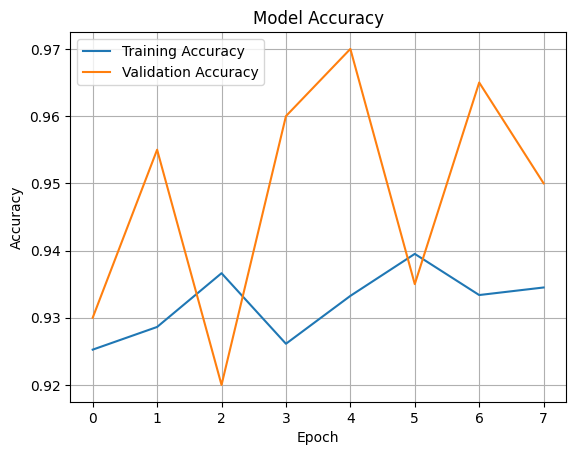

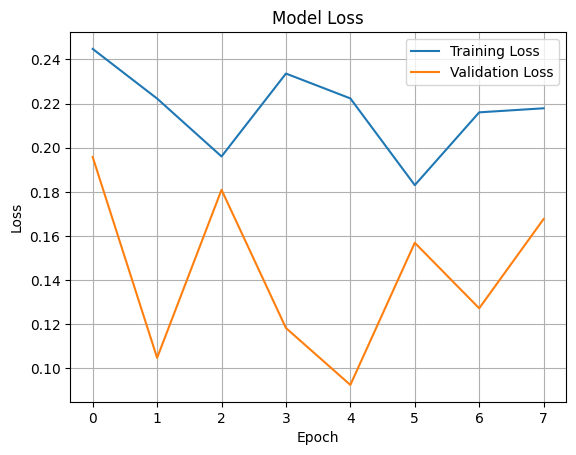

In [ ]:

# Plot Akurasi
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.9863 - loss: 0.0635


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9905 - loss: 0.0576

Akurasi Pengujian (Testing): 0.9870
Akurasi Akhir Training     : 0.9345
Akurasi Akhir Validasi     : 0.9500


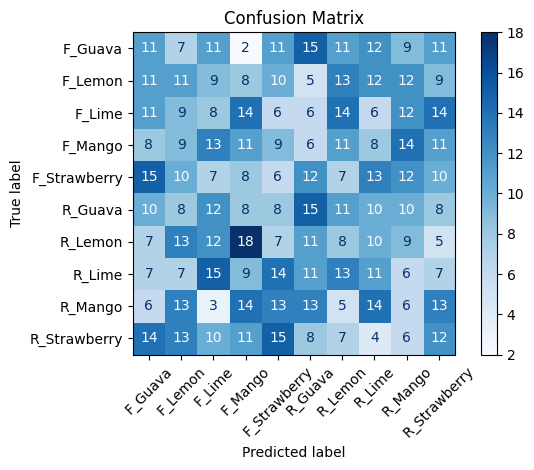

In [ ]:
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

y_true = test_data.classes


test_loss, test_acc = model.evaluate(test_data)
print(f"\nAkurasi Pengujian (Testing): {test_acc:.4f}")


final_train_acc = model_history.history['accuracy'][-1]
final_val_acc = model_history.history['val_accuracy'][-1]


print(f"Akurasi Akhir Training     : {final_train_acc:.4f}")
print(f"Akurasi Akhir Validasi     : {final_val_acc:.4f}")


cm = confusion_matrix(y_true, y_pred)


class_labels = list(test_data.class_indices.keys())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
model.export("submissionNew/saved_model")

Saved artifact at 'submissionNew/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_77')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133190734260624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190734262160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190734262352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190734261584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190734257936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190734261968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190734263888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190734264464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190734264656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133190734263504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1

In [ ]:
model.save("modelbuahbuah.h5")

In [ ]:
import tensorflow as tf

model=tf.keras.models.load_model('modelbuahbuah.h5')

tf.saved_model.save(model, 'modelbuah_saved_model')


converter = tf.lite.TFLiteConverter.from_saved_model('modelbuah_saved_model')
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
import tensorflow as tf
os.makedirs("submissionNew/tflite", exist_ok=True)
converter = tf.lite.TFLiteConverter.from_saved_model("submissionNew/saved_model")
tflite_model = converter.convert()


with open("submissionNew/tflite/model.tflite", "wb") as f:
    f.write(tflite_model)


with open("submissionNew/tflite/label.txt", "w") as f:
      for label in class_names:
        f.write(f"{label}\n")


In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    submissionNew/saved_model \
    submissionNew/tfjs_model

2025-04-24 01:44:51.915360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745459091.934961   42434 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745459091.940769   42434 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-24 01:44:56.398659: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1745459096.398859   42434 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [ ]:
shutil.make_archive('submissionNew', 'zip', 'submissionNew')

'/content/submissionNew.zip'

In [ ]:
!pip freeze > requirements.txt

In [ ]:
# === STEP 1: Upload file gambar ===
from google.colab import files
import os

uploaded = files.upload()

# Ambil nama file yang diupload
image_path = list(uploaded.keys())[0]
print(f"File yang diupload: {image_path}")


Saving rottenMango (9).jpg to rottenMango (9) (1).jpg
File yang diupload: rottenMango (9) (1).jpg


In [ ]:

import tensorflow as tf
import numpy as np
from PIL import Image

# Load model TFLite
interpreter = tf.lite.Interpreter(model_path="model (1).tflite")
interpreter.allocate_tensors()

with open("label.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]


In [ ]:


def load_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((150, 150))  # Sesuaikan ukuran input model
    img = np.array(img, dtype=np.float32) / 255.0  # Normalisasi
    img = np.expand_dims(img, axis=0)  # Tambah dimensi batch
    return img

def predict(image_path):
    img = load_image(image_path)
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    pred_index = np.argmax(output)
    confidence = np.max(output)

    print(f"{labels[pred_index]}")
    print(f"✅ Confidence: {confidence:.2f}")


In [ ]:
import matplotlib.pyplot as plt

def show_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Gambar Input")
    plt.show()


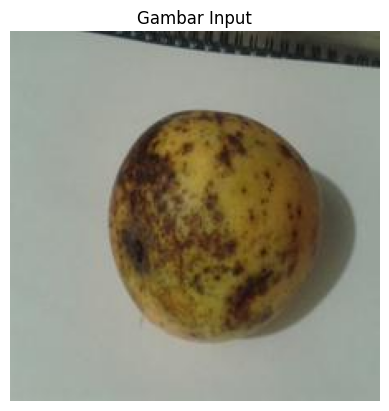

R_Mango
✅ Confidence: 1.00


In [ ]:
show_image(image_path)
predict(image_path)
